In [ ]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

In [ ]:
#Set configurations and read metadata
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
IMG_ROOT = 'D:/5th sem project/archive/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal',
           IMG_ROOT+'2_cataract',
           IMG_ROOT+'2_glaucoma',
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = 'D:/5th sem project/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('D:/5th sem project/ODIR-5K/data.xlsx')


In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [ ]:
#Process Cataract dataset
cat_df = pd.DataFrame(0,
                  columns=['paths',
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]

    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3

# only sample normal and cataract
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
0,D:/5th sem project/archive/dataset\1_normal/NL...,0
1,D:/5th sem project/archive/dataset\1_normal/NL...,0
2,D:/5th sem project/archive/dataset\1_normal/NL...,0
3,D:/5th sem project/archive/dataset\1_normal/NL...,0
4,D:/5th sem project/archive/dataset\1_normal/NL...,0
...,...,...
596,D:/5th sem project/archive/dataset\3_retina_di...,0
597,D:/5th sem project/archive/dataset\3_retina_di...,0
598,D:/5th sem project/archive/dataset\3_retina_di...,0
599,D:/5th sem project/archive/dataset\3_retina_di...,0


In [ ]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    601
Name: cataract, dtype: int64


In [ ]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))


In [ ]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [ ]:
le_df.head()


,cataract,paths
0,1,D:/5th sem project/ODIR-5K/Training Images/0_l...
1,0,D:/5th sem project/ODIR-5K/Training Images/1_l...
2,0,D:/5th sem project/ODIR-5K/Training Images/2_l...
3,0,D:/5th sem project/ODIR-5K/Training Images/3_l...
4,0,D:/5th sem project/ODIR-5K/Training Images/4_l...


In [ ]:
re_df.head()


,cataract,paths
0,0,D:/5th sem project/ODIR-5K/Training Images/0_r...
1,0,D:/5th sem project/ODIR-5K/Training Images/1_r...
2,0,D:/5th sem project/ODIR-5K/Training Images/2_r...
3,0,D:/5th sem project/ODIR-5K/Training Images/3_r...
4,0,D:/5th sem project/ODIR-5K/Training Images/4_r...


In [ ]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())


Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


In [ ]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']),
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [ ]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,D:/5th sem project/ODIR-5K/Training Images/0_l...
81,1,D:/5th sem project/ODIR-5K/Training Images/81_...
103,1,D:/5th sem project/ODIR-5K/Training Images/103...
119,1,D:/5th sem project/ODIR-5K/Training Images/119...
253,1,D:/5th sem project/ODIR-5K/Training Images/254...


In [ ]:
df = pd.concat([cat_df, ocu_df], ignore_index=True)
df

,paths,cataract
0,D:/5th sem project/archive/dataset\1_normal/NL...,0
1,D:/5th sem project/archive/dataset\1_normal/NL...,0
2,D:/5th sem project/archive/dataset\1_normal/NL...,0
3,D:/5th sem project/archive/dataset\1_normal/NL...,0
4,D:/5th sem project/archive/dataset\1_normal/NL...,0
...,...,...
1222,D:/5th sem project/ODIR-5K/Training Images/943...,0
1223,D:/5th sem project/ODIR-5K/Training Images/294...,0
1224,D:/5th sem project/ODIR-5K/Training Images/395...,0
1225,D:/5th sem project/ODIR-5K/Training Images/199...,0


In [ ]:
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [ ]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [00:46<00:00,  5.31it/s]


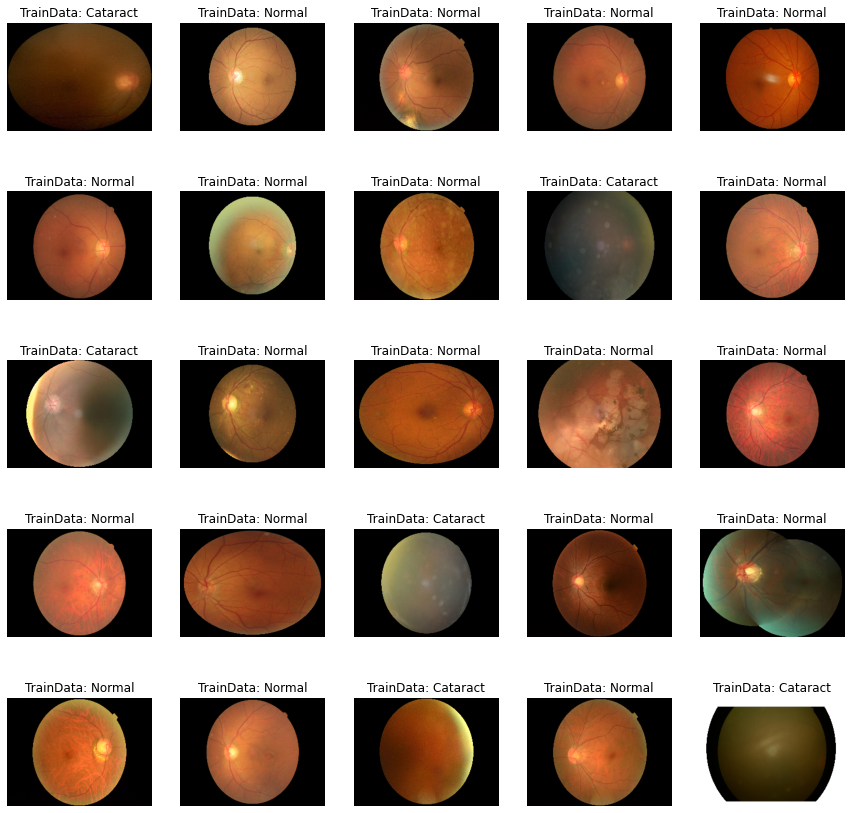

In [ ]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

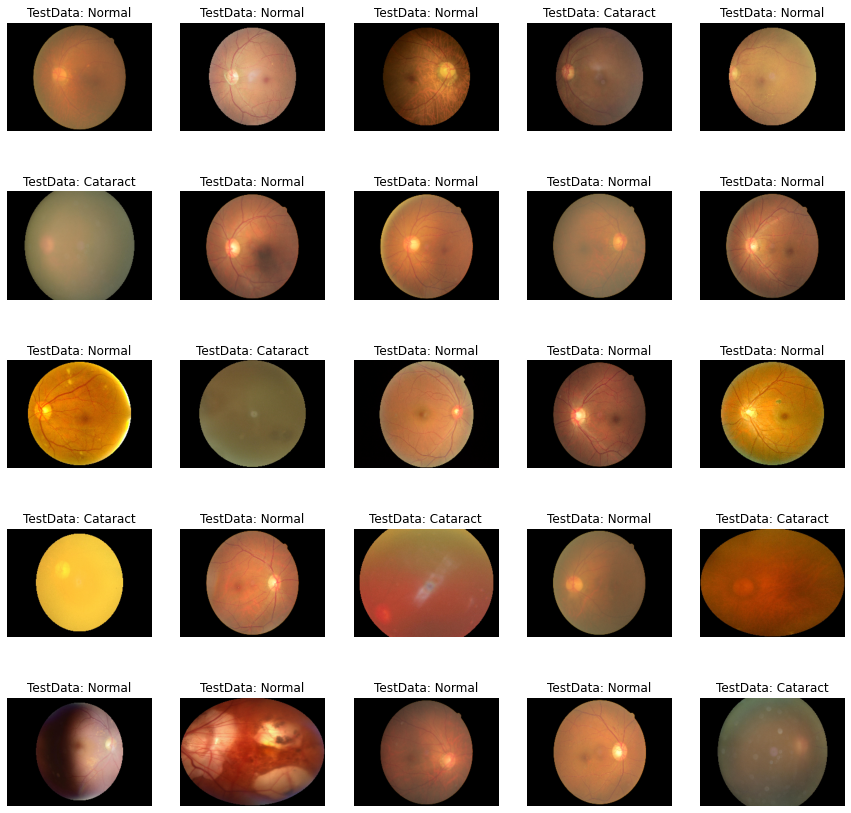

In [ ]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [ ]:
class Mish(tf.keras.layers.Layer):

    def _init_(self, **kwargs):
        super(Mish, self)._init_(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * tf.tanh(tf.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.tanh(1+tf.exp(x))))(x)

get_custom_objects().update({'mish': Activation(mish)})

In [ ]:
# new add
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as k
from keras.layers import Layer



from keras import backend as K
from keras.layers import Layer
class MyCustomLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyCustomLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel = self.add_weight(name = 'kernel',
      shape = (input_shape[1], self.output_dim),
      initializer = 'normal', trainable = True)
        super(MyCustomLayer, self).build(input_shape)
    def call(self, input_data): return K.dot(input_data, self.kernel)
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=4, padding='same',
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=4, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(4))
model.add(Dropout(0.4))
model.add(Conv2D(16, kernel_size=4, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=4, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(4))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(MyCustomLayer(4)) #add mycustomlayer



model.add(Dense(2,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 256, 16)      784       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 256, 16)      4112      
                                                                 
 batch_normalization (BatchN  (None, 192, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 64, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 64, 16)        4

In [ ]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')



es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
26/26 [==============================] - 94s 3s/step - loss: 1.8894 - accuracy: 0.7023 - val_loss: 0.7175 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 90s 3s/step - loss: 1.1030 - accuracy: 0.7287 - val_loss: 0.4888 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 88s 3s/step - loss: 1.0315 - accuracy: 0.7599 - val_loss: 0.7482 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 88s 3s/step - loss: 1.0529 - accuracy: 0.7575 - val_loss: 0.7192 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 90s 3s/step - loss: 0.8921 - accuracy: 0.7599 - val_loss: 0.9211 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 86s 3s/step - loss: 0.7104 - accuracy: 0.7875 - val_loss: 0.4590 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 71s 3s/step - loss: 0.6

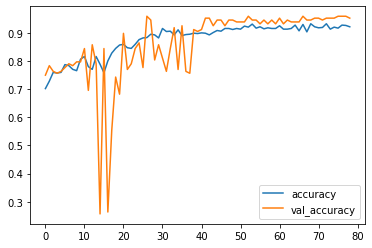

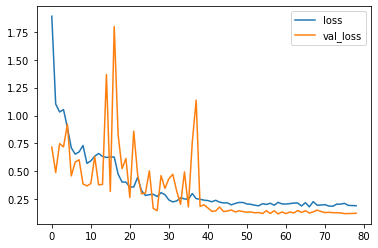

In [ ]:
history = model.fit(generator.flow(train_imgs,
                                   train_df,
                                   batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model.evaluate(test_imgs, test_df)

8/8 [==============================] - 3s 408ms/step - loss: 0.1599 - accuracy: 0.9350


[0.1599465161561966, 0.934959352016449]

In [ ]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n),
        weights='imagenet',
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 efficientnet-b0 (Functional  (None, 6, 8, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
generator = ImageDataGenerator(horizontal_flip=True,
                               height_shift_range=0.1,
                               fill_mode='reflect')



es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
26/26 [==============================] - 180s 6s/step - loss: 0.7635 - accuracy: 0.4514 - val_loss: 0.5358 - val_accuracy: 0.7500 - lr: 3.0000e-06
Epoch 2/100
26/26 [==============================] - 154s 6s/step - loss: 0.6878 - accuracy: 0.5570 - val_loss: 0.5382 - val_accuracy: 0.7568 - lr: 3.0000e-06
Epoch 3/100
26/26 [==============================] - 154s 6s/step - loss: 0.6332 - accuracy: 0.6459 - val_loss: 0.5264 - val_accuracy: 0.7635 - lr: 3.0000e-06
Epoch 4/100
26/26 [==============================] - 156s 6s/step - loss: 0.5697 - accuracy: 0.7563 - val_loss: 0.5045 - val_accuracy: 0.7703 - lr: 3.0000e-06
Epoch 5/100
26/26 [==============================] - 154s 6s/step - loss: 0.5311 - accuracy: 0.8067 - val_loss: 0.4873 - val_accuracy: 0.7905 - lr: 3.0000e-06
Epoch 6/100
26/26 [==============================] - 163s 6s/step - loss: 0.5053 - accuracy: 0.8103 - val_loss: 0.4775 - val_accuracy: 0.8041 - lr: 3.0000e-06
Epoch 7/100
26/26 [===========================

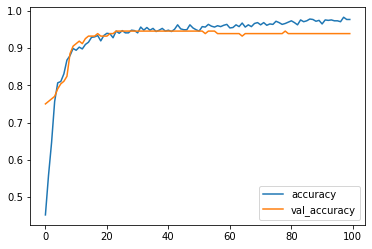

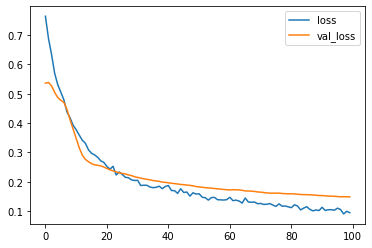

In [ ]:
history = model.fit(generator.flow(train_imgs,
                                   train_df,
                                   batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model.evaluate(test_imgs, test_df)

8/8 [==============================] - 9s 1s/step - loss: 0.1203 - accuracy: 0.9593


[0.12027830630540848, 0.9593495726585388]